In [1]:
import shutil
!cp /content/drive/MyDrive/Bay/corn.zip ./
shutil.unpack_archive('./corn.zip','./data')
shutil.unpack_archive('/content/data/train/good/good.zip','/content/data/train/good')
shutil.unpack_archive('/content/data/train/bad/bad.zip','/content/data/train/bad')
shutil.unpack_archive('/content/data/test/good/good1.zip','/content/data/test/good')
shutil.unpack_archive('/content/data/test/bad/bad1.zip','/content/data/test/bad')
!rm /content/data/train/good/good.zip
!rm /content/data/train/bad/bad.zip
!rm /content/data/test/good/good1.zip
!rm /content/data/test/bad/bad1.zip

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet121,NASNetMobile,EfficientNetB2,MobileNetV3Small
from tensorflow.keras.layers import Dense,Dropout,concatenate
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import functools
from skimage import io, filters, measure, morphology, img_as_ubyte
from io import BytesIO

In [3]:
data_path = '/content/data/test/'
model_path = '/content/drive/MyDrive/Bay/corn_monilenet_96.h5'
model_name = "mobilenet"
pre_train = "imagenet"
N_Sample= 500
num_classes = 2
img_len = 96
img_width = 96
shape = (img_len,img_width)
input_shape = (img_len , img_width , 3)

In [4]:
def model_setup(network):
    if network == "mobilenet":
        based_model = MobileNetV2(include_top = False,
                                weights = pre_train,
                                pooling = 'avg',
                                input_shape = input_shape)
        
    x = based_model.output
    x = Dense(num_classes, activation = "softmax") (x)
    model_functional = tf.keras.Model(inputs = based_model.input , outputs = x)
    
    return model_functional
    
model = model_setup(model_name)
    
model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [5]:
base_lr = 0.005
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_lr),
             loss = 'categorical_crossentropy',
             metrics = ["accuracy"])

In [6]:
# reading the saved model and changing the learning rate
model.load_weights(model_path)
new_model = tf.keras.Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [7]:
import itertools    

def batch_generator(iterable, batch_size=N_Sample):
    iterable = iter(iterable)

    while True:
        batch = list(itertools.islice(iterable, batch_size))
        if len(batch) > 0:
            yield batch
        else:
            break

def read_img(file, Path, shape = shape):
  img = cv2.resize(np.array(Image.open(Path+file)), shape , 
                                   interpolation = cv2.INTER_LINEAR) 
  return (img/255.)


In [8]:
Path = data_path + 'bad/'
files_B = os.listdir(Path)

for batch_B in batch_generator(files_B[0:N_Sample], N_Sample):
  img_batch_B = np.array(list(map(functools.partial(read_img , Path=Path), batch_B))) 
  feature_B = new_model(img_batch_B)
  predict_B = model.predict(img_batch_B)
  predict_B = np.around(predict_B.astype(np.float64),decimals=2)

In [9]:
Path = data_path + 'good/'
files_G = os.listdir(Path)

for batch_G in batch_generator(files_G[0:N_Sample], N_Sample):
  img_batch_G = np.array(list(map(functools.partial(read_img , Path=Path), batch_G)))
  feature_G = new_model(img_batch_G)
  predict_G = model.predict(img_batch_G)
  predict_G = np.around(predict_G.astype(np.float64),decimals=2)

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(list(feature_B)+list(feature_G))

In [11]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

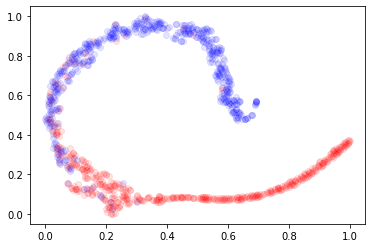

In [12]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tx[:N_Sample], ty[:N_Sample], color='red', alpha=0.1)
ax.scatter(tx[N_Sample:], ty[N_Sample:], color='blue', alpha=0.1)

plt.show()

In [13]:
# Make Panda DataFrame

df = pd.DataFrame({"File":  [data_path+'bad/'+img for img in batch_B] + [data_path+'good/'+img for img in batch_G],
             "GT": ['Bad'] * N_Sample + ['Good'] * N_Sample,
              "Predict": predict_B.tolist() + predict_G.tolist(),
              "T_SNE_x": tx.tolist(),
              "T_SNE_y": ty.tolist()})

In [14]:
import pickle
import base64
from io import BytesIO
from PIL import Image

new_image_string=[]
for im in df['File']:
  image = Image.open(im)
  img = np.array(image)

  pil_img = Image.fromarray(img)
  buff = BytesIO()
  pil_img.save(buff, format="png")
  new_image_string.append('data:image/png;base64,'+base64.b64encode(buff.getvalue()).decode("utf-8"))

df['Image'] = new_image_string

In [15]:
# Standard imports 

from bokeh.io import output_notebook, show
output_notebook()

In [16]:
# Plot a complex chart with interactive hover in a few lines of code

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral5

In [17]:
source = ColumnDataSource(df)

In [18]:
p = figure(plot_width=1000, plot_height=800, title="T-SNE for Good and bad corn data ",
           x_range = [-0.2,1.2] , y_range= [-0.2,1.2] , tools="pan,box_select,zoom_in,zoom_out,save,reset")

#p.xgrid.grid_line_color = None
#p.xaxis.axis_label = "Manufacturer grouped by # Cylinders"

p.circle(x='T_SNE_x', y='T_SNE_y', size=7, fill_color=factor_cmap('GT', palette= ['red','blue'] , factors=source.data['GT'].tolist(),) , alpha=0.2, source=source)

hover = HoverTool()
hover.tooltips="""
        <div>
          <div><strong>GT: </strong>@GT</div>
          <div><strong>Prediction: </strong>@Predict</div>
            <div>
                <img
                src="@Image" height="60" alt="image"
                style="float: left; margin: 0px 15px 15px 0px; image-rendering: pixelated;"
                border="2"
                >
            </div>
        </div>
"""
p.add_tools(hover)

show(p)

/usr/local/lib/python3.7/dist-packages/bokeh/models/mappers.py:147: UserWarning: Palette length does not match number of factors. ['Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', '